In [1]:
# Set up
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
import altair as alt
alt.renderers.enable('notebook') # enable altair rendering
from scipy.stats import ttest_ind # t-tests
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt # plotting
import matplotlib
from sklearn import metrics
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
listings_df = pd.read_csv('./data/with_amenities_and_estimated_income.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
listings_df.columns.values
amenities_columns = list(listings_df.columns.values[99:-1])
amenities_columns.remove('translation missing: en.hosting_amenity_50')

In [5]:
columns = ['id', 'estimated_income_per_month', 'host_since', 'host_is_superhost', 'host_listings_count', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet']
columns_with_amenities = list(columns) + list(amenities_columns)
df = listings_df[columns_with_amenities]

# Data Visualizations

In [6]:
df

,id,estimated_income_per_month,host_since,host_is_superhost,host_listings_count,property_type,room_type,accommodates,bathrooms,bedrooms,...,Accessible-height toilet,Alfresco bathtub,Safety card,Cooking basics,Flat path to front door,Free street parking,Lock on bedroom door,Lake access,Jetted tub,Cat(s)
0,2318,789.0,2008-08-26,t,2,House,Entire home/apt,8,2.5,4.0,...,0,0,0,0,0,0,0,0,0,0
1,4291,1312.0,2009-09-02,f,5,House,Private room,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,5682,1008.0,2009-03-03,t,1,Guest suite,Entire home/apt,2,1.0,0.0,...,0,0,0,0,1,1,0,0,0,0
3,6606,1740.0,2009-04-26,t,4,Apartment,Entire home/apt,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,9419,1365.0,2009-08-09,t,6,Apartment,Private room,2,3.0,1.0,...,0,0,1,1,0,1,1,0,0,0
5,9460,1680.0,2009-08-10,t,4,Condominium,Private room,2,1.0,1.0,...,0,0,1,0,0,0,1,0,0,0
6,9531,1128.0,2009-08-13,f,2,House,Entire home/apt,4,1.0,2.0,...,0,0,1,0,0,0,0,0,0,0
7,9534,854.0,2009-08-13,f,2,Guest suite,Entire home/apt,3,1.0,2.0,...,0,0,0,1,1,0,0,0,0,0
8,9596,1700.0,2009-04-26,t,4,Apartment,Entire home/apt,4,1.0,1.0,...,0,0,0,1,0,1,0,0,0,0
9,9909,1062.0,2009-08-23,t,10,Guest suite,Entire home/apt,4,1.0,2.0,...,0,0,0,1,0,1,0,0,0,0


## Does the number of accommodates really mean more income?

[(0, 20000)]

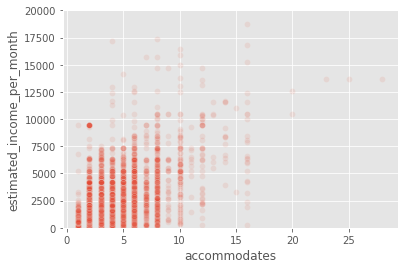

In [7]:
plot = sns.scatterplot(x="accommodates", y="estimated_income_per_month", sizes=(10, 200), alpha=0.1, data=df)
plot.set(ylim=(0,20000))

## Do homes owned by owners with many listings make more money?

The first plot shows that there are a few owners who own hundreds of AirBnbs that make a range of income per month. 

However, looking at owners with < 25 listings, it seems like owners that only own one AirBnb tend to make the most on their listing.

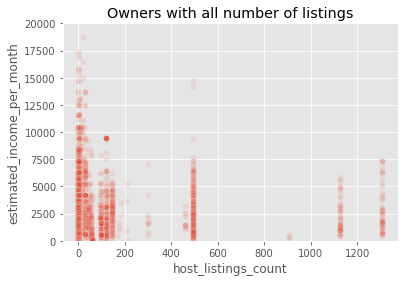

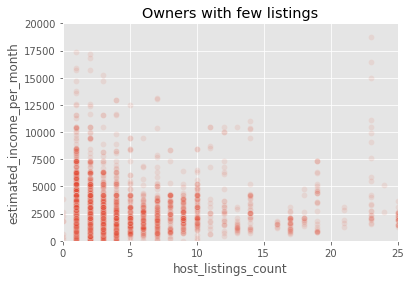

In [8]:
plot = sns.scatterplot(x="host_listings_count", y="estimated_income_per_month", sizes=(10, 200), alpha=0.1, data=df)
plot.set(ylim=(0,20000))
plot.set_title('Owners with all number of listings')
plt.show()

plot = sns.scatterplot(x="host_listings_count", y="estimated_income_per_month", sizes=(10, 200), alpha=0.1, data=df)
plot.set(ylim=(0,20000), xlim=(0,25))
plot.set_title('Owners with few listings')
plt.show()

## What ammenities increase monthly income?

There are 178 features for amenities. While a lot of these may help in predicting monthly income, our model should be based on features that a user could enter in a form. This means that we probably need to pick a subset of amenities to base our model off of.

In [1]:
amenities_related_to_income = list()

for col in list(amenities_columns):
    # get income of houses with and without the given amenity
    with_amenity = df[df[col] == 1]['estimated_income_per_month']
    without_amenity = df[df[col] == 0]['estimated_income_per_month']
    # remove nan values from income
    with_amenity = [x for x in with_amenity if not np.isnan(x)]
    without_amenity = [x for x in without_amenity if not np.isnan(x)]
    
    # perform t-test
    t, p = ttest_ind(with_amenity, without_amenity, equal_var=False)
    if (p < 0.000000000000000000000001):
        # if the p value is small enough add to our list of amenities
        amenities_related_to_income.append(col)
        
print(len(amenities_related_to_income))

NameError: name 'amenities_columns' is not defined

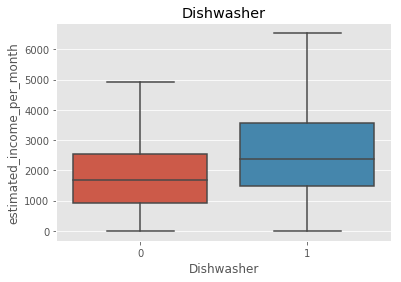

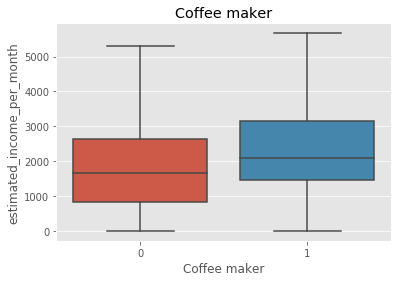

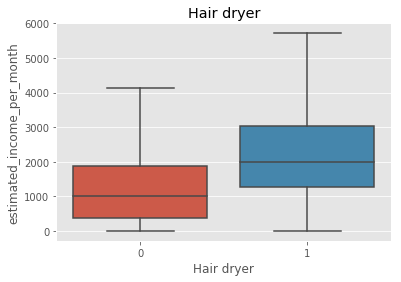

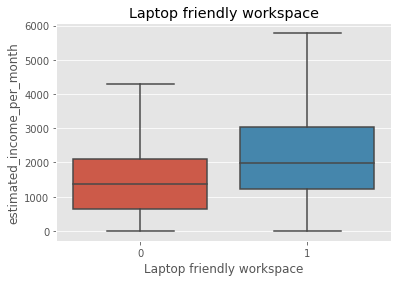

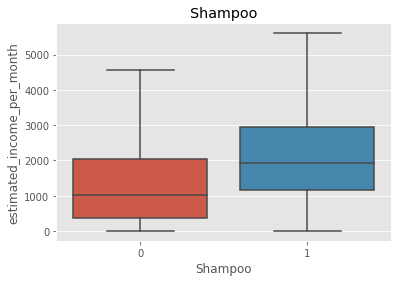

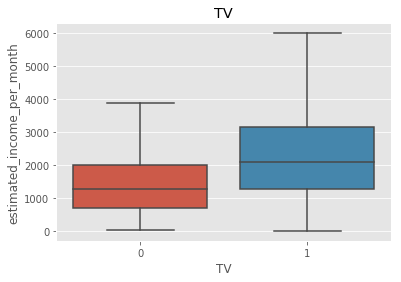

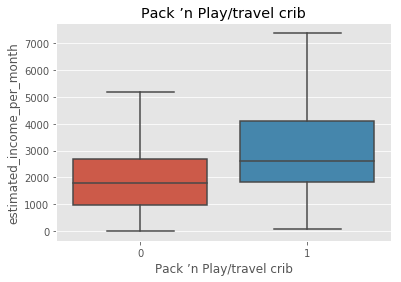

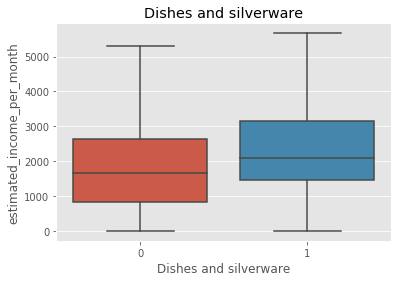

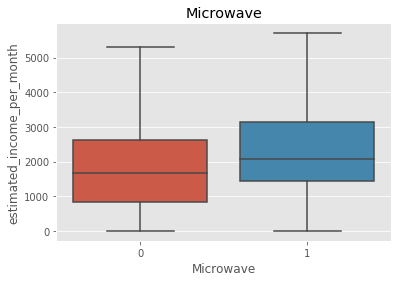

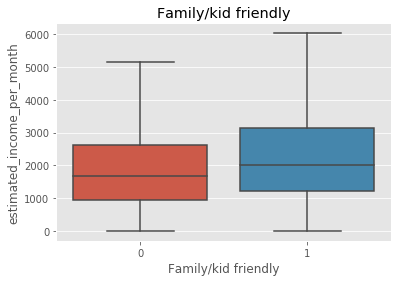

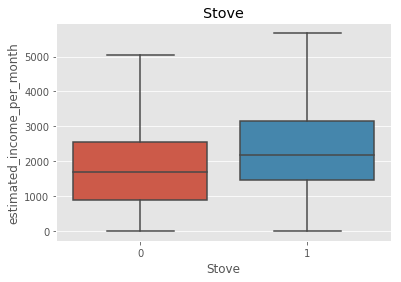

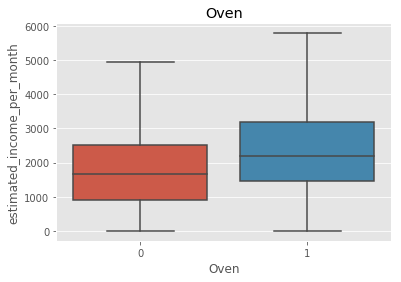

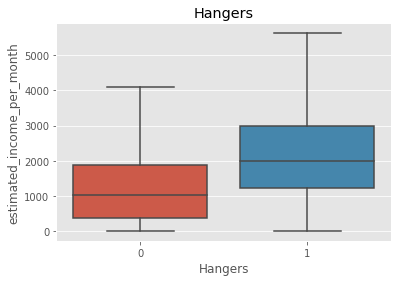

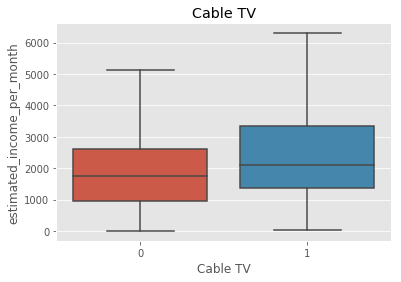

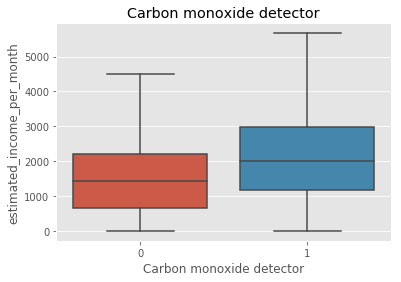

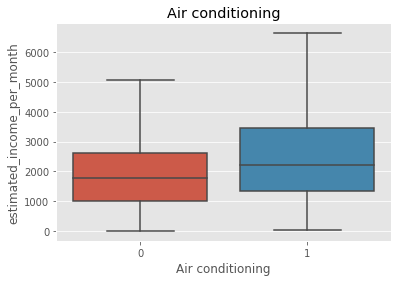

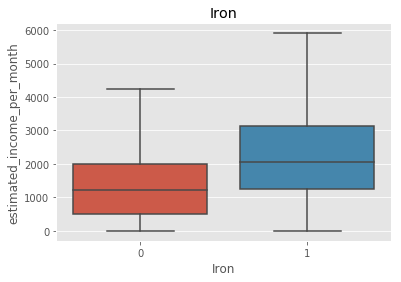

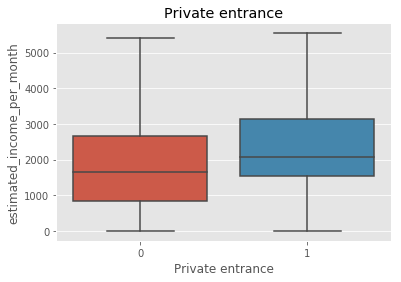

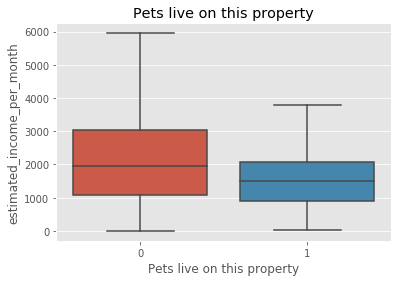

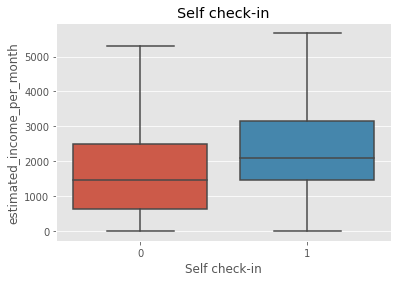

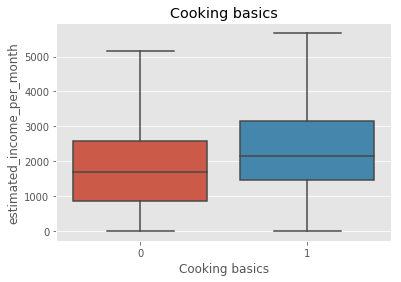

In [31]:
for col in list(amenities_related_to_income):
    plot = sns.boxplot(x=col, y="estimated_income_per_month", showfliers=False, data=df)
    plot.set_title(col)
    plt.show()

## What about bedrooms, bathrooms, sqft?

The following plots show that bedrooms and bathrooms increase the estimated income of the home. However, the square feet plot was a bit suprising because there are spikes at 500, 600, and 1000 square feet that make the regression pretty weird.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


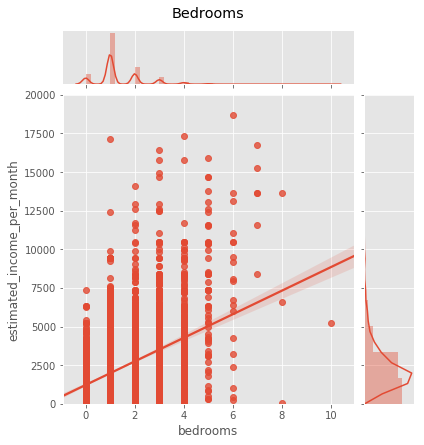

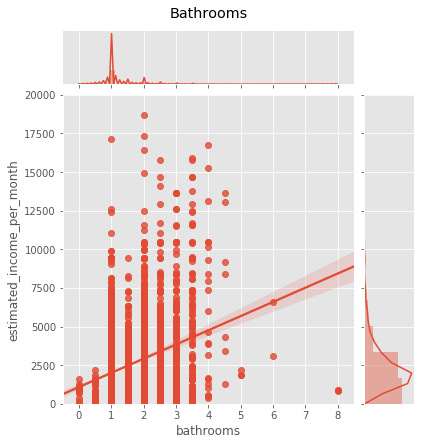

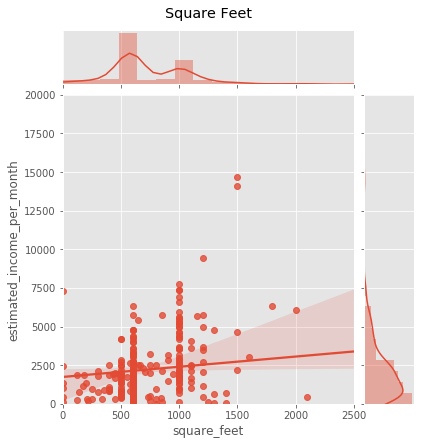

In [11]:
plot = sns.jointplot(x="bedrooms", y="estimated_income_per_month",kind="reg",ylim=(0, 20000), data=df)
plt.title('Bedrooms', y=1.23)
plt.show()

plot = sns.jointplot(x="bathrooms", y="estimated_income_per_month",kind="reg",ylim=(0, 20000), data=df)
plt.title('Bathrooms', y=1.23)
plt.show()

plot = sns.jointplot(x="square_feet", y="estimated_income_per_month",kind="reg", ylim=(0, 20000), xlim=(0,2500), data=df)
plt.title('Square Feet', y=1.23)
plt.show()